[[이유한님] 캐글 코리아 캐글 스터디 커널 커리큘럼](https://kaggle-kr.tistory.com/32)

[TensorFlow Speech Recognition Challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge)

[Speech representation and data exploration](https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration)

In [1]:
import os
import zipfile
import py7zr
import warnings
warnings.filterwarnings("ignore")

# dir_path = './input/006_tensorflow-speech-recognition-challenge/'

# fp_zip = "./input/tensorflow-speech-recognition-challenge.zip"
# with zipfile.ZipFile(fp_zip, "r") as f:
#     f.extractall(dir_path)

# from glob import glob
# fp_7zs = glob("./input/006_tensorflow-speech-recognition-challenge/*.7z")
# for file in glob("./input/006_tensorflow-speech-recognition-challenge/*.7z"):
#     with py7zr.SevenZipFile(file, 'r') as f:
#         f.extractall(dir_path)

# [os.remove(f) for f in fp_7zs + [fp_zip]];

Introduction
Hello! This is my very first Kernel. It is meant to give a grasp of a problem of speech representation. I'd also like to take a look on a features specific to this dataset.

Content:

- 1. Visualization of the recordings - input features
  - 1.1. Wave and spectrogram
  - 1.2. MFCC
  - 1.3. Sprectrogram in 3d
  - 1.4. Silence removal
  - 1.5. Resampling - dimensionality reductions
  - 1.6. Features extraction steps
- 2. Dataset investigation
  - 2.1. Number of files
  - 2.2. Mean spectrograms and fft
  - 2.3. Deeper into recordings
  - 2.4. Length of recordings
  - 2.5. Note on Gaussian Mixtures modeling
  - 2.6. Frequency components across the words
  - 2.7. Anomaly detection
- 3. Where to look for the inspiration

All we need is here:

In [2]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

#Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
# import librosa
"pip install librosa"

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib

Using matplotlib backend: module://matplotlib_inline.backend_inline


# 1. Visualization

There are two theories of a human hearing - place ( https://en.wikipedia.org/wiki/Place_theory_(hearing) (frequency-based) and temporal (https://en.wikipedia.org/wiki/Temporal_theory_(hearing) ) In speech recognition, I see two main tendencies - to input [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) (frequencies), and more sophisticated features MFCC - Mel-Frequency Cepstral Coefficients, PLP. You rarely work with raw, temporal data.

Let's visualize some recordings!

# DeepL 번역

인간의 청각에는 장소( https://en.wikipedia.org/wiki/Place_theory_(청각)(주파수 기반)와 시간적(https://en.wikipedia.org/wiki/Temporal_theory_(청각))이라는 두 가지 이론이 있습니다. 음성 인식에서는 [스펙트로그램](https://en.wikipedia.org/wiki/Spectrogram)(주파수)과 보다 정교한 기능인 MFCC(멜-주파수 세프랙 계수, PLP)를 입력하는 두 가지 주요 경향을 볼 수 있습니다. 원시, 시간적 데이터로 작업하는 경우는 거의 없습니다.
녹음을 시각화해 봅시다!

## 1.1. Wave and spectrogram:

Choose and read some file:

In [3]:
# train_audio_path = '../input/train/audio/'
train_audio_path = './input/006_tensorflow-speech-recognition-challenge/train/audio/'
filename = "./yes/0a7c2a8d_nohash_0.wav"
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)

Define a function that calculates spectrogram.

Note, that we are taking logarithm of spectrogram values. It will make our plot much more clear, moreover, it is strictly connected to the way people hear. We need to assure that there are no 0 values as input to logarithm.

In [4]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sample_rate,
                                            window="hann",
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Frequencies are in range (0, 8000) according to [Nyquist theorem](https://en.wikipedia.org/wiki/Nyquist_rate).

Let's plot it:

Text(0.5, 0, 'Seconds')

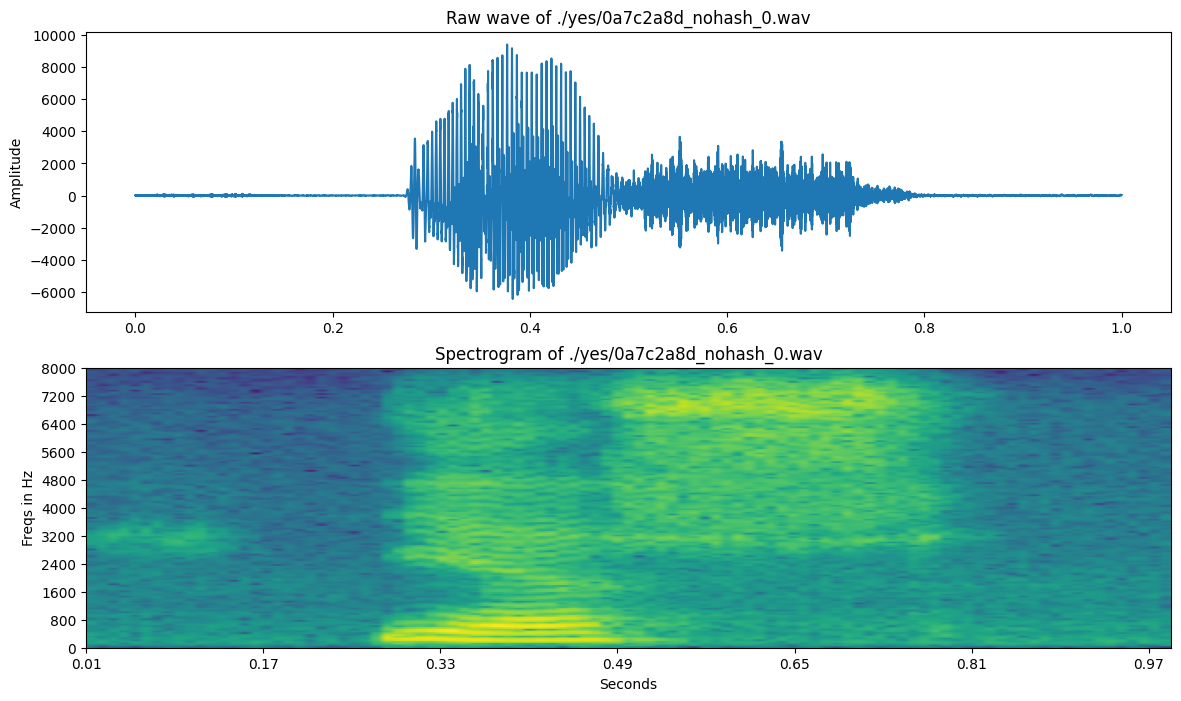

In [5]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
ax1.set_title("Raw wave of " + filename)
ax1.set_ylabel("Amplitude")
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect="auto", origin="lower",
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title("Spectrogram of " + filename)
ax2.set_ylabel("Freqs in Hz")
ax2.set_xlabel("Seconds")

https://www.kaggle.com/code/davids1992/speech-representation-and-data-exploration